In [65]:
pip install kaggle --upgrade

Note: you may need to restart the kernel to use updated packages.


In [66]:
pip show kaggle

Name: kaggle
Version: 1.6.17
Summary: Kaggle API
Home-page: https://github.com/Kaggle/kaggle-api
Author: Kaggle
Author-email: support@kaggle.com
License: Apache 2.0
Location: c:\users\user\anaconda3\envs\ju_env\lib\site-packages
Requires: bleach, certifi, python-dateutil, python-slugify, requests, six, tqdm, urllib3
Required-by: 
Note: you may need to restart the kernel to use updated packages.


In [67]:
!kaggle config view

Configuration values from C:\Users\USER\.kaggle
- username: seohyoun
- path: None
- proxy: None
- competition: None


In [68]:
# titanic 데이터 다운로드
!kaggle competitions download -c titanic

titanic.zip: Skipping, found more recently modified local copy (use --force to force download)


## 데이터 분석

In [69]:
import shutil

filename = 'titanic.zip' # 압축 해제할 파일 이름
extrac_dir = 'titanic' # 압축 해제할 폴더 이름
archive_format = 'zip' # 압축 파일 형태

shutil.unpack_archive(filename, extrac_dir, archive_format)

In [70]:
import pandas as pd
import numpy as np

train = pd.read_csv('titanic/train.csv')
test = pd.read_csv('titanic/test.csv')

In [71]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


## Data dictionary

survived: 0 = No, 1 = Yes

pclass: Ticket class, 1 = 1st, 2 = 2nd, 3 = 3rd

sibsp: # of siblings / spouses abroad the Titanic

parch: # of parents / children abroad the Titanic

ticket: Ticket number

cabin: Cabin number

embraked: Port of Embarkation, C = Cherbourg, Q = Queenstown, S = Southampton


In [72]:
test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


데이터를 확인해보면 train.csv에는 survived가 있으나 test.csv에는 survived가 없음

우리가 해야 하는 것이 train.csv를 바탕으로 test.csv에 있는 사람들의 생존 여부를 알아내는 모델을 만들어야 하기 때문

In [73]:
# train.csv가 892개의 승객 데이터와 12개의 feature 데이터를 가지고 있다는 것을 의미
train.shape

(891, 12)

In [74]:
# test.csv가 418명의 승객 데이터와 11개의 feature 데이터를 가지고 1개의 feature 데이터 survived를 알아내야 함
test.shape

(418, 11)

In [101]:
train.info()
##NaN는 데이터 전처리 과정을 통해 바꿔줘야 함

# Age와 Cabin, Embarked에서 missing data가 있다는 것을 알 수 있다.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Sex          891 non-null    int64  
 4   Age          714 non-null    float64
 5   SibSp        891 non-null    int64  
 6   Parch        891 non-null    int64  
 7   Ticket       891 non-null    object 
 8   Fare         891 non-null    float64
 9   Cabin        204 non-null    object 
 10  Embarked     889 non-null    object 
 11  Title        889 non-null    float64
dtypes: float64(3), int64(6), object(3)
memory usage: 83.7+ KB


In [102]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Sex          418 non-null    int64  
 3   Age          332 non-null    float64
 4   SibSp        418 non-null    int64  
 5   Parch        418 non-null    int64  
 6   Ticket       418 non-null    object 
 7   Fare         417 non-null    float64
 8   Cabin        91 non-null     object 
 9   Embarked     418 non-null    object 
 10  Title        418 non-null    int64  
dtypes: float64(2), int64(6), object(3)
memory usage: 36.0+ KB


In [103]:
train.isnull().sum()
## train.csv의 feature 당 null의 개수 확인

PassengerId      0
Survived         0
Pclass           0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
Title            2
dtype: int64

In [104]:
test.isnull().sum()
## test.csv의 feature 당 null의 개수 확인

PassengerId      0
Pclass           0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
Title            0
dtype: int64

In [105]:
### 시각화

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()

## Bar Chart for Categorial Features
Pclass

Sex

Sibsp

Parch

Embarked

Cabin

In [106]:
def bar_chart(feature):
    survived = train[train['Survived']==1][feature].value_counts()
    dead = train[train['Survived']==0][feature].value_counts()
    df = pd.DataFrame([survived, dead])
    df.index = ['Survived','dead']
    df.plot(kind='bar', stacked = True, figsize = (10,5))


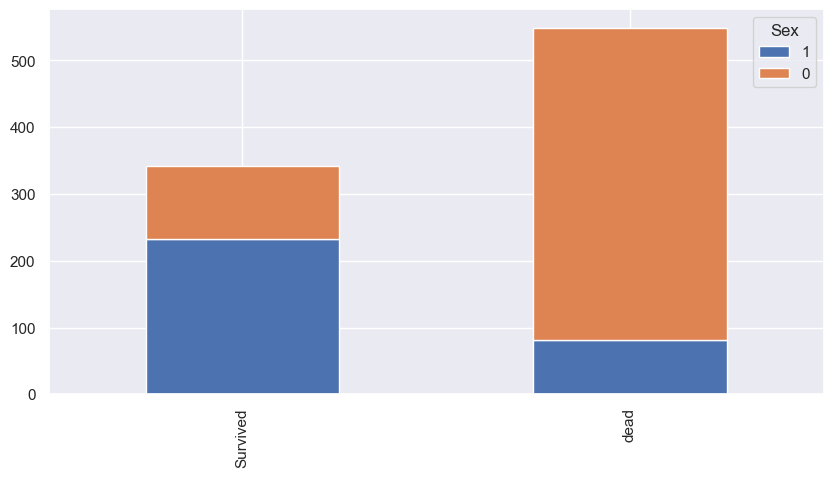

In [107]:
bar_chart('Sex')

### The Chart confirms female more likely survived than male

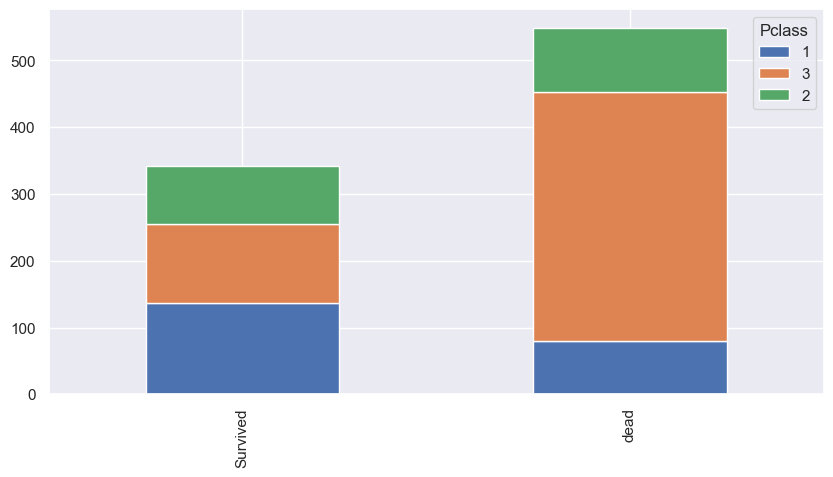

In [108]:
bar_chart('Pclass')

### The Chart confirms 1st class more likely survived than other classes
### The Chart confirms 3rd class more likely dead than other classes

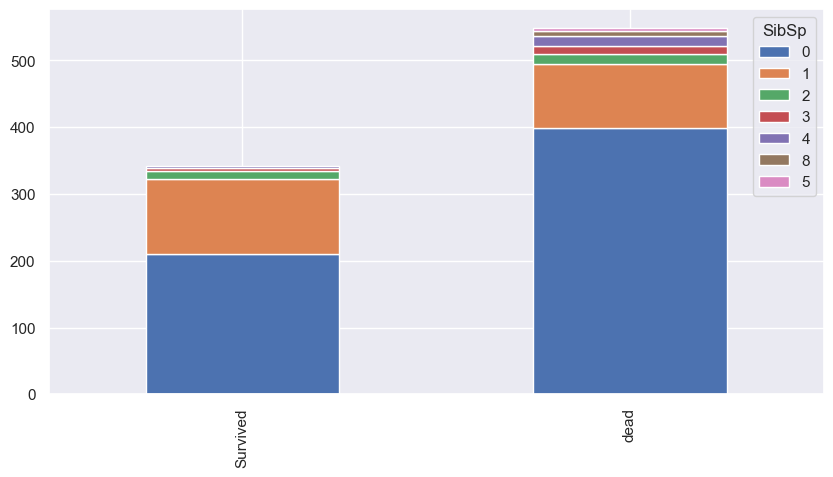

In [109]:
bar_chart('SibSp')

### The Chart confirms a person aboarded with more than 2 siblings or spouse more likely survived
### The Chart confirms a person aboared without siblings or spouse more likely dead

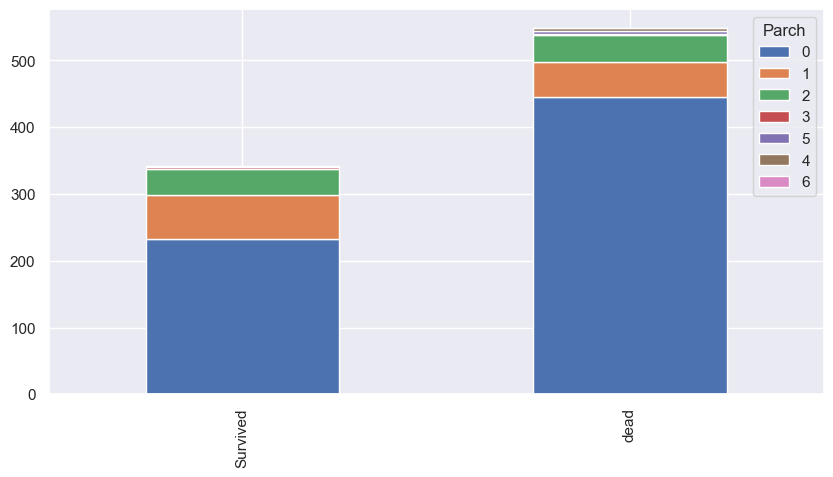

In [110]:
bar_chart('Parch')

### The Chart confirms a person aboarded with more than 2 parents or children more likely survived
### The Chart confirms a person aboarded alone more likely dead

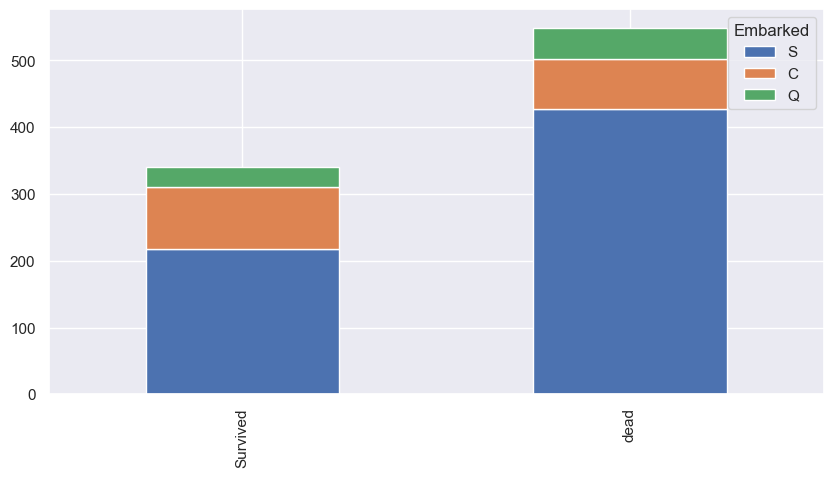

In [111]:
bar_chart('Embarked')

### The Chart confirms a person aboarded from C slightly more likely survived
### The Chart confirms a person aboarded from Q more likely dead
### The Chart confirms a person aboarded from S more likely dead

## Feature engineering

In [112]:
# feature vector를 만듣어야 함
## 텍스트로 되어있는 걸 기계가 이해하기 쉬운 숫자로 변환해주는 과정
## NaN 이상치, 결측치 등을 제거해줘야 함

In [113]:
train_test_data = [train, test] # combining train dataset and test dataset

for dataset in train_test_data:
    dataset['Title'] = dataset['Name'].str.extract('([A-Za-z]+)\.', expand = False)
### [A-Za-z]+)\. 는 그냥 정규표현식

KeyError: 'Name'

#### 4.1 name

In [ ]:
# name 전체는 생존에 큰 영향을 끼치지는 않지만 name feature에서 Mr, Mrs 등을 통하여 성별을 유추해낼 수 있음, 그 외에 나머지 이름은 삭제
train['Title'].value_counts()

In [ ]:
test['Title'].value_counts()

In [ ]:
title_mapping = {
    "Mr": 0, "Miss": 1, "Mrs": 2, "Master": 3, "Dr": 3, "Rev": 3, "Col":3, "Major": 3, 
    "Mile": 3, "Countess": 3, "Ms": 3, "Lady": 3, "Jonkheer": 3, "Don": 3, "Dona": 3, "Mme": 3, "Capt": 3, "Sir": 3
}

for dataset in train_test_data:
    dataset['Title'] = dataset['Title'].map(title_mapping)

In [ ]:
train.head()

In [ ]:
bar_chart('Title')

In [ ]:
# delete unnecessary feature from dataset
train.drop("Name", axis = 1, inplace = True)
test.drop("Name", axis = 1, inplace = True)

# train.drop()	train 데이터프레임에서 특정 열 또는 행을 삭제
# "Name"	삭제할 대상 (여기서는 "Name" 열)
# axis=1	1이면 열(column) 삭제, 0이면 행(row) 삭제
# inplace=True	True이면 원본 데이터에서 직접 삭제, False이면 새로운 데이터프레임 반환

In [ ]:
train.head()

In [ ]:
test.head()

### 4.3 Sex
male: 0, female: 1

In [ ]:
sex_mapping = {"male": 0, "female": 1}

for dataset in train_test_data:
    dataset["Sex"] = dataset["Sex"].map(sex_mapping)

In [ ]:
bar_chart("Sex")

### 4.4 age

#### 4.4.1 some in missing age
Let's ues Title's median age for missing age

In [117]:
train.head(100)

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title
0,1,0,3,0,22.0,1,0,A/5 21171,7.2500,NaN,S,0.0
1,2,1,1,1,38.0,1,0,PC 17599,71.2833,C85,C,2.0
2,3,1,3,1,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,1.0
3,4,1,1,1,35.0,1,0,113803,53.1000,C123,S,2.0
4,5,0,3,0,35.0,0,0,373450,8.0500,NaN,S,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
95,96,0,3,0,NaN,0,0,374910,8.0500,NaN,S,0.0
96,97,0,1,0,71.0,0,0,PC 17754,34.6542,A5,C,0.0
97,98,1,1,0,23.0,0,1,PC 17759,63.3583,D10 D12,C,0.0
98,99,1,2,1,34.0,0,1,231919,23.0000,NaN,S,2.0


In [119]:
# fill missing age with median age for each title (Mr, Mrs, Miss, Others)
train["Age"] = train.groupby("Title")["Age"].transform("median")
test["Age"] = test.groupby("Title")["Age"].transform("median")

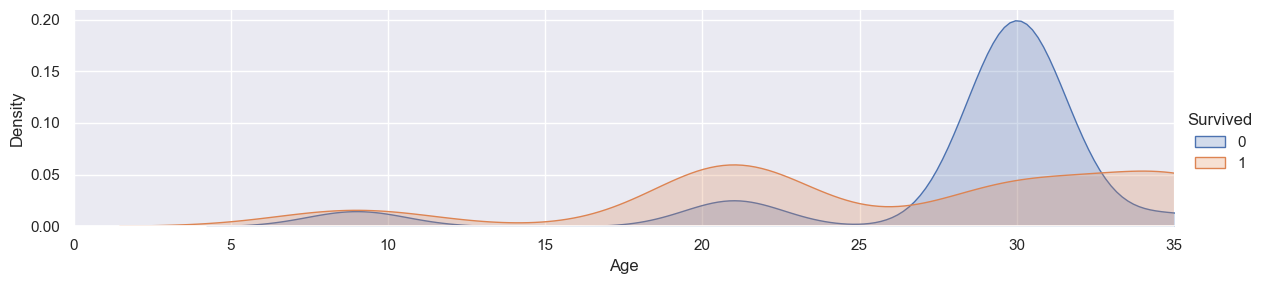

In [123]:
facet = sns.FacetGrid(train, hue = "Survived", aspect = 4)
facet.map(sns.kdeplot,"Age",fill = True)
facet.set(xlim = (0,train["Age"].max()))
facet.add_legend()

plt.show()

(0.0, 20.0)

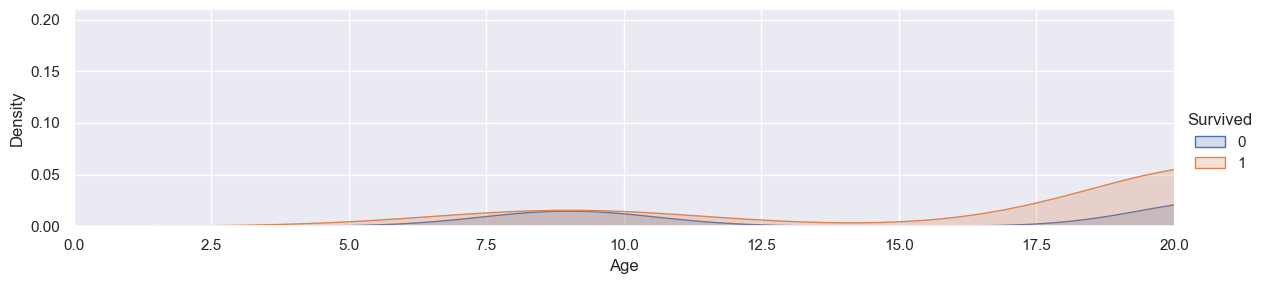

In [124]:
facet = sns.FacetGrid(train, hue = "Survived", aspect = 4)
facet.map(sns.kdeplot,"Age",fill = True)
facet.set(xlim = (0,train["Age"].max()))
facet.add_legend()

plt.xlim(0,20)

(20.0, 30.0)

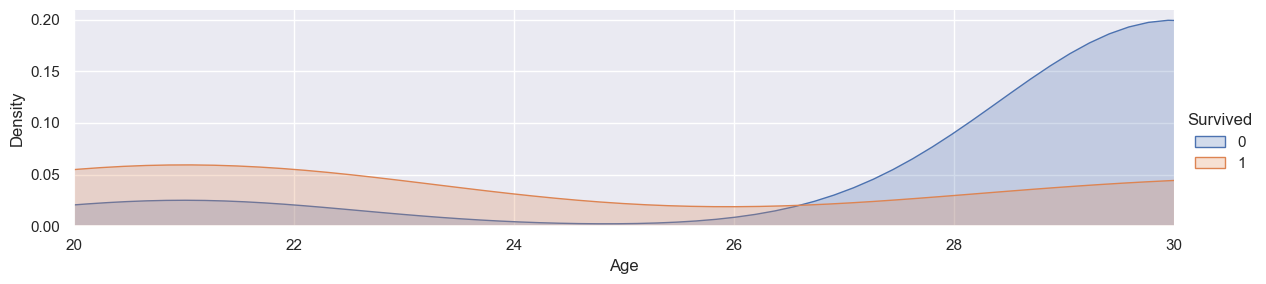

In [126]:
facet = sns.FacetGrid(train, hue = "Survived", aspect = 4)
facet.map(sns.kdeplot,"Age",fill = True)
facet.set(xlim = (0,train["Age"].max()))
facet.add_legend()

plt.xlim(20,30)

(30.0, 40.0)

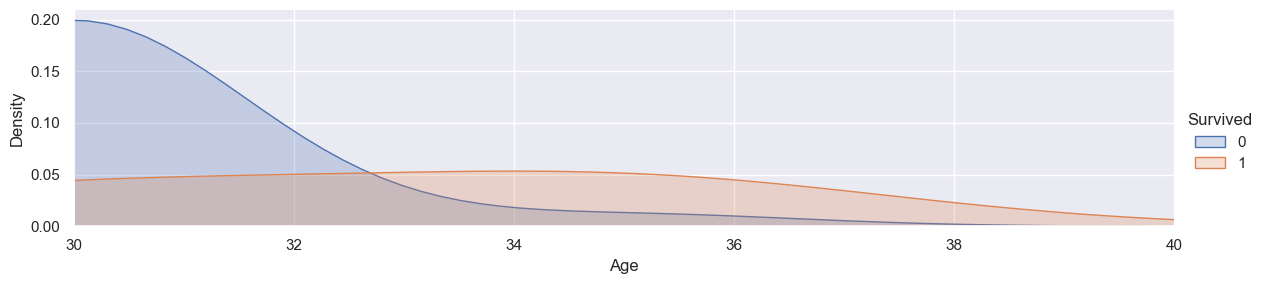

In [127]:
facet = sns.FacetGrid(train, hue = "Survived", aspect = 4)
facet.map(sns.kdeplot,"Age",fill = True)
facet.set(xlim = (0,train["Age"].max()))
facet.add_legend()

plt.xlim(30,40)

(40.0, 60.0)

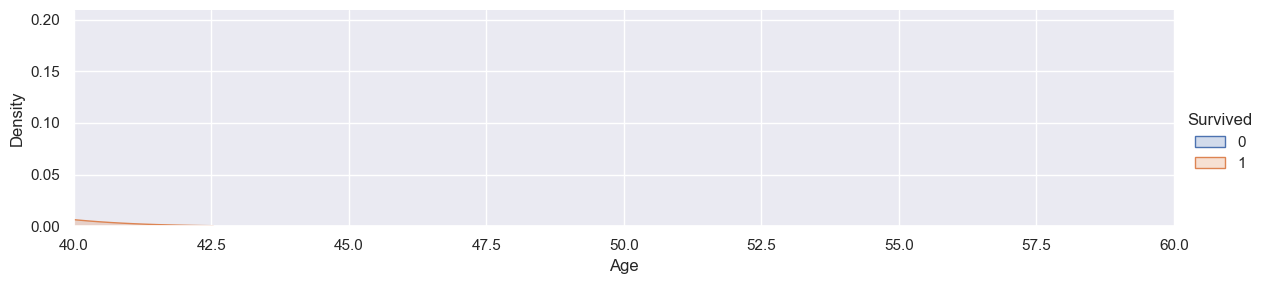

In [128]:
facet = sns.FacetGrid(train, hue = "Survived", aspect = 4)
facet.map(sns.kdeplot,"Age",fill = True)
facet.set(xlim = (0,train["Age"].max()))
facet.add_legend()

plt.xlim(40,60)

(60.0, 80.0)

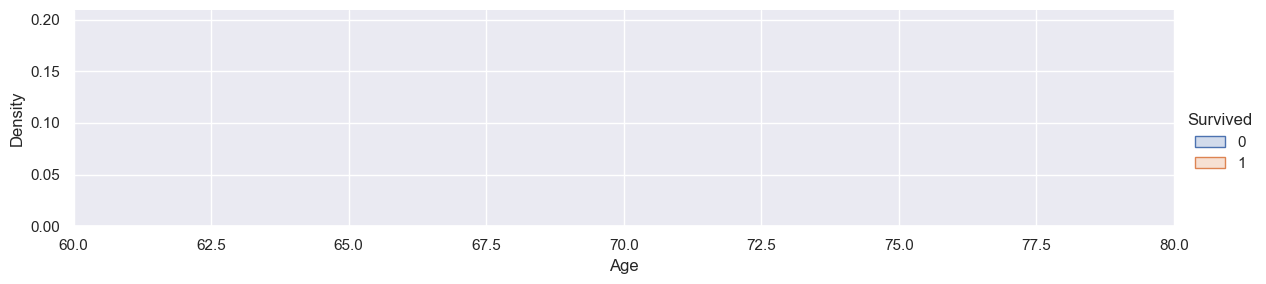

In [130]:
facet = sns.FacetGrid(train, hue = "Survived", aspect = 4)
facet.map(sns.kdeplot,"Age",fill = True)
facet.set(xlim = (0,train["Age"].max()))
facet.add_legend()

plt.xlim(60,80)

In [135]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Sex          891 non-null    int64  
 4   Age          889 non-null    float64
 5   SibSp        891 non-null    int64  
 6   Parch        891 non-null    int64  
 7   Ticket       891 non-null    object 
 8   Fare         891 non-null    float64
 9   Cabin        204 non-null    object 
 10  Embarked     889 non-null    object 
 11  Title        889 non-null    float64
dtypes: float64(3), int64(6), object(3)
memory usage: 83.7+ KB


In [136]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Sex          418 non-null    int64  
 3   Age          418 non-null    float64
 4   SibSp        418 non-null    int64  
 5   Parch        418 non-null    int64  
 6   Ticket       418 non-null    object 
 7   Fare         417 non-null    float64
 8   Cabin        91 non-null     object 
 9   Embarked     418 non-null    object 
 10  Title        418 non-null    int64  
dtypes: float64(2), int64(6), object(3)
memory usage: 36.0+ KB


### 4.4.2 Binning
binning